In [1]:
import pandas as pd
import numpy as np
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import t, ttest_ind
from pandas import Series, DataFrame
from statsmodels.stats import weightstats as stests

pd.options.display.float_format = '{:.1f}'.format
df = pd.read_csv('movies.csv')

In [2]:
#keeping only the necessary columns
df = df[['Title', 'Worldwide Gross', 'Production Budget', 'Release Date', 'Major Genre', 'Rotten Tomatoes Rating', 'IMDB Rating', 'IMDB Votes']]
#renaming some columns
df.rename(columns = {'Worldwide Gross' : 'Gross', 'Production Budget' : 'Budget', 'Release Date' : 'Date', 'Major Genre' : 'Genre', 'Rotten Tomatoes Rating' : 'RTRating', 'IMDB Rating' : 'IMDBRating', 'IMDB Votes' : 'IMDBVotes'}, inplace = True)

In [3]:
#cropping unnecessary info from Date
df.Date = df['Date'].str.rstrip()
df.Date = df['Date'].str[-2:]

In [4]:
#pruning unwanted rows from Date
df = df[df['Date'].str.isdecimal() == True]

#pruning unwanted rows from Gross
df = df[df['Gross'] != 'Unknown']

In [5]:
#fixing indices after pruning (starting from 1 instead of 0)
df.index = np.arange(1, len(df) + 1)

In [6]:
#fixing Date format
df.Date = pd.to_numeric(df['Date'], errors = 'coerce')
df.Date = df['Date'].map("{:02}".format)
df.Date = df['Date'].apply(lambda x:'20'+x if 0 <= int(x) <= 19 else '19'+x)
df.Date = df['Date'].astype(int)

In [7]:
#converting Gross from str to float
df.Gross = df['Gross'].astype(float)

In [8]:
#fixing scale climax on RTRating
df.RTRating = df['RTRating'].apply(lambda x: x/10)

In [9]:
#to csv -print to see how clean data looks like
df.to_csv('cleandata_movies.csv', index_label = 'ID')

print(df)

                           Title       Gross     Budget  Date  \
1                 The Land Girls    146083.0  8000000.0  1998   
2         First Love, Last Rites     10876.0   300000.0  1998   
3     I Married a Strange Person    203134.0   250000.0  1998   
4           Let's Talk About Sex    373615.0   300000.0  1998   
5                           Slam   1087521.0  1000000.0  1998   
...                          ...         ...        ...   ...   
3183  Zack and Miri Make a Porno  36851125.0 24000000.0  2008   
3184                      Zodiac  83080084.0 85000000.0  2007   
3185                        Zoom  12506188.0 35000000.0  2006   
3186         The Legend of Zorro 141475336.0 80000000.0  2005   
3187           The Mask of Zorro 233700000.0 65000000.0  1998   

                  Genre  RTRating  IMDBRating  IMDBVotes  
1                   NaN       nan         6.1     1071.0  
2                 Drama       nan         6.9      207.0  
3                Comedy       nan         

In [10]:
#making Production Budget and Gross Dataframe ---for my data mining problem ---
budget_gross_df = df[['Gross', 'Budget']]
budget_gross_df = budget_gross_df.dropna()

#print(budget_gross_df)

In [11]:
#making a genres Dataframe splitting the one column to two (Columns: ID, First, Second)----helpful---- 
genres_df = df['Genre'].dropna()
genres_df = genres_df.str.split('/', expand = True)
genres_df.columns = ['First', 'Second']

second_genre = genres_df['Second'].dropna()

#print(genres_df)

In [12]:
#constructing a dictionary for Genre (key = genre : value = number of movies)
genres_hash = {}

for i in genres_df['First']:

    if i not in genres_hash:

        genres_hash[i] = 1

    else:

        genres_hash[i] += 1


for i in second_genre:

    if i not in genres_hash:

        genres_hash[i] = 1

    else:

        genres_hash[i] += 1

In [13]:
#making the Genre - Number of Movies Dataframe so as to make the bar plot later
genre_numbers_df = pd.DataFrame.from_dict(genres_hash, orient = 'index')
genre_numbers_df.columns = ['Number of Movies']
genre_numbers_df.sort_values('Number of Movies', ascending = False, inplace = True)
genre_numbers_df.reset_index(level = 0, inplace = True)
genre_numbers_df = genre_numbers_df.rename(columns = {'index' : 'Genre'})

#print(genre_numbers_df)

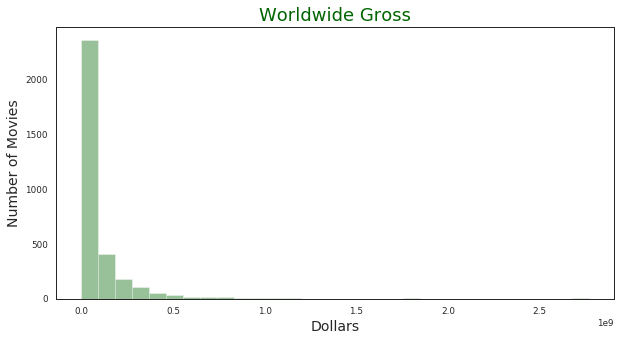

In [14]:
#making Worldwide Gross histogram
sns.set_context('paper')
sns.set_style('white')

gross = df['Gross']

plt.figure(figsize=(10, 5))
sns.distplot( gross, kde = False, color = 'darkgreen', bins = 30)

plt.title('Worldwide Gross', color = 'darkgreen', fontsize = 18)
plt.xlabel('Dollars', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

plt.savefig('WorldwideGross_Histogram.png')

Skewed Non Symmetric (Non-Normal) Right-long-tailed Histogram ----Follows Geometric Distribution----

- Data are located in the left side.
   
- Scale of data: interval [0.0 – 2767891499.0] dollars.
  The spread of data is not really wide. Note that our data points, range from $0 up to $2767891499, 
     
- The histogram is “skewed” , there is no-mirroring of the data. 
    
- This distribution is non-symmetric. It has a long tail (on the right) relative to the other tail (left
  side has no tail at all). This phenomenon occurs, beacause the lower bounds of the data are 
  significantly more frequent than the upper bounds.

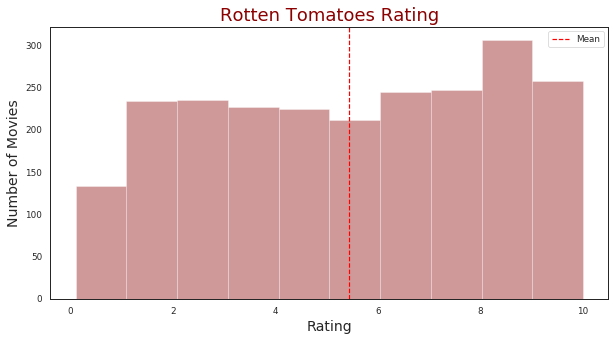

In [15]:
#making Rotten Tomatoes Rating histogram
rtr = df['RTRating'].dropna()

plt.figure(figsize=(10, 5))
sns.distplot(rtr, kde = False, color='darkred', bins = 10)

plt.title('Rotten Tomatoes Rating',color = 'darkred', fontsize = 18)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

mean = rtr.mean()
plt.axvline(mean, color='r', linestyle='--')
plt.legend({'Mean':mean})

plt.savefig('RottenTomatoesRating_Histogram.png')

Symmetric 1 peak Unimodal short–tailed Histogram ----1 peak Unimodal Distribution ----

- Data, cluster around a single mode (1 peak unimodal). Tails here, approach zero very fast. We could say 
  that Rotten Tomatoes ratings are well-distributed, ratings vary a lot and overspread through whole data 
  scale 
     
- Scale of data : interval [0.1,10.0] points. 
   
- No skewness.

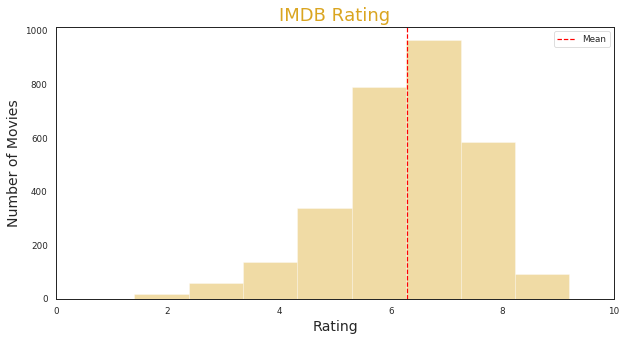

In [16]:
#making IMDB Rating histogram
imdbr = df['IMDBRating'].dropna()

plt.figure(figsize=(10, 5))
sns.distplot(imdbr, kde = False, color='goldenrod', bins = 8)

plt.xlim(0, 10)
plt.title('IMDB Rating',color = 'goldenrod', fontsize = 18)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Number of Movies', fontsize=14)

mean = imdbr.mean()
plt.axvline(mean, color='r', linestyle='--')
plt.legend({'Mean':mean})

plt.savefig('IMDBRating_Histogram.png')

Skewed Non-Symmetric Normal moderate-tailed Histogram ----follows Normal Distribution----
  
- Data are normally distributed with a litle skewness to the right. IMDB Ratings follow the normal 
  distribution, centrality is around 6 and 7 points and as we can see there is a tendency for higher 
  voting than lower.
      
- Scale of data : interval [1.4, 9.2] points**. We managed to contain the whole scale.
    
- There is a litle right skewness and we conclude that most ratings tend to be higher than the middle rating 
  point of the scale (that is, number 5).

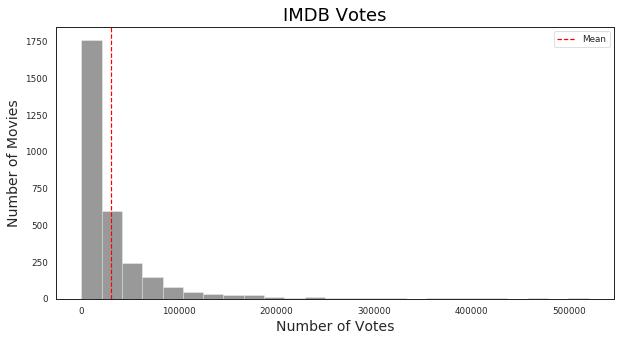

In [17]:
#making IMDB Votes histogram
imdbv = df['IMDBVotes'].dropna()

plt.figure(figsize=(10, 5))
sns.distplot(imdbv, kde = False, color = 'black', bins = 25)

plt.title('IMDB Votes',color = 'black', fontsize = 18)
plt.xlabel('Number of Votes', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

mean = imdbv.mean()
plt.axvline(mean, color='r', linestyle='--')
plt.legend({'Mean':mean})

plt.savefig('IMDBVotes_Histogram.png')

Skewed Non Symmetric (Non-Normal) Right-long-tailed Histogram ----follows Geometric Distribution----
    
- Most of the data are located in the left side and with a first glance we could say that the centrality
  of the number of votes is in the first two bins.
      
- Scale of data : interval [18, 519541] votes. We managed to contain the whole scale. Data are not 
  normally spread all along the interval.
      
- Again, data are skewed to the left and this distribution is non-symmetric. It has a long tail (on the 
  right) relative to the other tail (left side has no tail at all). This phenomenon occurs, due to huge 
  dispersion of our data points, huge difference between lower and upper bounds (as we explained above).
      

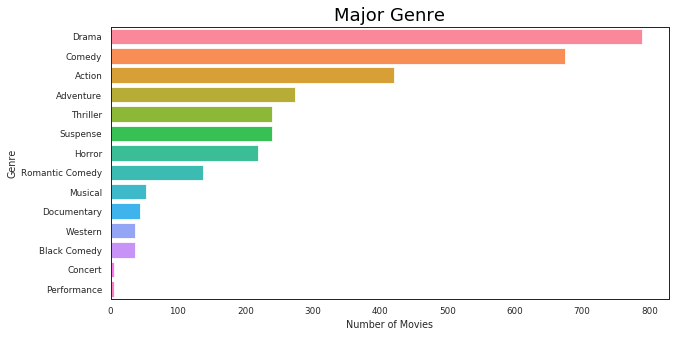

In [18]:
#making Genres Bar Plot
plt.figure(figsize=(10, 5))

sns.barplot(x = 'Number of Movies', y = 'Genre', saturation = 1, data = genre_numbers_df)

plt.title('Major Genre', color = 'black', fontsize = 18)

plt.savefig('num_movie_genre_barplot.png')

Number of Movies per Genre Barplot  “Oh! Too much DRAMA” 

The barplot shows some interesting analytics for what kind of movie, Production Companies, prefer to 
release. 
There is a tendency to fund and therefore, produce more “Drama” and “Comedy” movies. 
The bronze metal goes to “Action” films and “Performance” and “Concert” genres come last.

In [19]:
#merging Gross with IMDBVotes into one DataFrame
gross_votes_df = pd.merge(pd.DataFrame(gross), pd.DataFrame(imdbv), left_index = True, right_index = True)

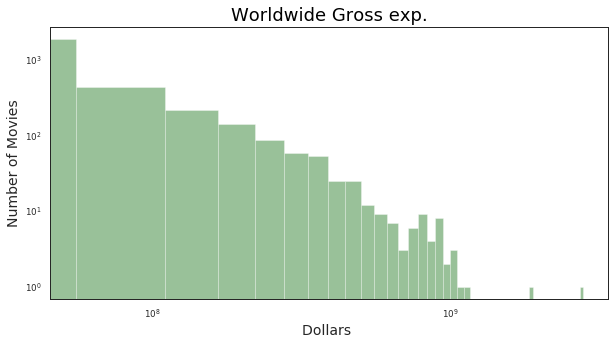

In [20]:
#making exp. Worldwide Gross Histogram
plt.figure(figsize=(10, 5))
sns.distplot(gross_votes_df['Gross'], kde = False, color = 'darkgreen', label = 'Gross', bins = 50)

plt.xscale('log')
plt.yscale('log')

plt.title('Worldwide Gross exp.',color = 'black', fontsize = 18)
plt.xlabel('Dollars ', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

plt.savefig('Grosslog_Histogram.png')

Worldwide Gross Histogram (exponential bins)

- Data points are gathered in the left side.

- The bins get “thinner” as they grow exponentially.

- It seems that Worldwide Gross follow exponential regression with two outliers in the right side that managed   to form small bins. Outliers should be seriously considered.

- There are huge deviations from the mean and the climax of data is large enough (high upper bounds) to      
  increase the mean number a lot.

- They show us the great dispersion that movies can have on their revenue. Big money is for the minority!

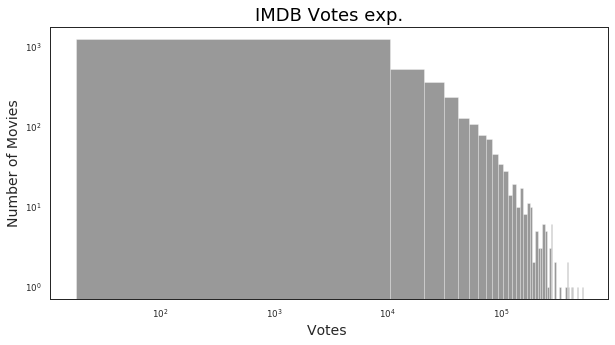

In [21]:
#making exp. IMDB Votes Histogram
plt.figure(figsize=(10, 5))
sns.distplot(gross_votes_df['IMDBVotes'] , kde = False, color = 'black', label = 'IMDBVotes', bins = 50)

plt.xscale('log')
plt.yscale('log')

plt.title('IMDB Votes exp.',color = 'black', fontsize = 18)
plt.xlabel('Votes ', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

plt.savefig('Voteslog_Histogram.png')

IMDB Votes Histogram (exponential bins)

- IMDB votes follow exponential regression. 

- There are a few movies that reach up to 10^5 votes . 

- As the votes increase, bins contain less and less quantity of data.

- Data are gathered in the left side.

- The tail drops significantly and the bins get “thinner”. 

- There are some tiny outliers in the right side which means that there are huge deviations 
  from the mean and the climax of data is large enough (high upper bounds) to increase the mean number a lot.

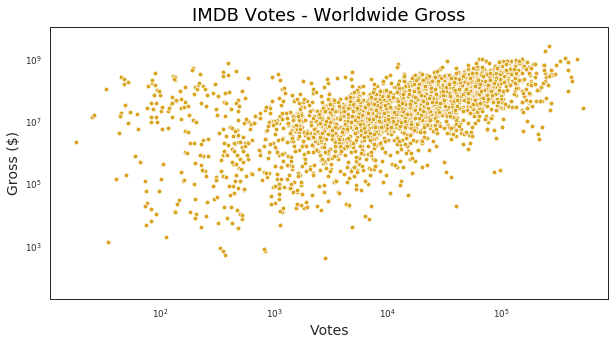

In [22]:
#making exp. Worldwide Gross and IMDB Votes Scatterplot

plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'IMDBVotes', y = 'Gross', data = gross_votes_df, facecolor = 'goldenrod' )

plt.xscale('log')
plt.yscale('log')
plt.ylim(20)

plt.title('IMDB Votes - Worldwide Gross',color = 'black', fontsize = 18)
plt.xlabel('Votes', fontsize = 14)
plt.ylabel('Gross ($)', fontsize = 14)

plt.savefig('VotesGrosslog_Scatterplot.png')

Worldwide Gross and IMDB Votes Scatterplot (exponential bins)

In this scatterplot, it is easy to realize that there is a high positive linear correlation between the revenues and IMDB votes. Most data points are clustered together as x and y axis increases. 

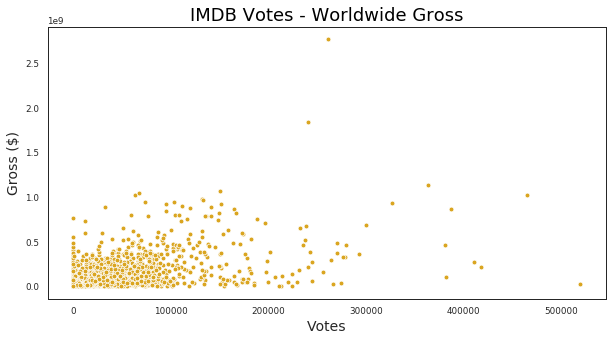

In [23]:
#making Worldwide Gross and IMDB Votes Scatterplot

plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'IMDBVotes', y = 'Gross', data = gross_votes_df, facecolor = 'goldenrod' )

plt.title('IMDB Votes - Worldwide Gross',color = 'black', fontsize = 18)
plt.xlabel('Votes', fontsize = 14)
plt.ylabel('Gross ($)', fontsize = 14)

plt.savefig('VotesGross_Scatterplot.png')

Worldwide Gross and IMDB Votes Scatterplot   
    
As we can see from the IMDB Votes – Worldwide Gross Scatterplot, there is a strong clustering in the 
left corner of the axis. 
As vote axis increases, gross axis looks to stay around the same values.
Therefore, we could make a hypothesis that says: “ Movies are more popular online “. 

In [24]:
#Pearson Correlation Coefficient: Worldwide Gross and IMDB Votes
pd.options.display.float_format = '{:.6f}'.format
gross_votes_df.corr(method = 'pearson')

,Gross,IMDBVotes
Gross,1.000000,0.551452
IMDBVotes,0.551452,1.000000


In [25]:
#Spearman Correlation Coefficient: Worldwide Gross and IMDB Votes
gross_votes_df.corr(method = 'spearman')

,Gross,IMDBVotes
Gross,1.000000,0.655319
IMDBVotes,0.655319,1.000000


In [26]:
#2 sample z-test: Worldwide Gross and IMDB Votes
print('H0: Movies are more popular online, than in the cinema.\n ')

ztest, pval = stests.ztest(gross_votes_df['IMDBVotes'], x2 = gross_votes_df['Gross'], value = 0, alternative = 'larger')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')
    
pd.options.display.float_format = '{:.1f}'.format

H0: Movies are more popular online, than in the cinema.
 
p-value:  1.0

Accept Null Hypothesis (H0)


In [27]:
#concatenating RTRating with IMDBRating into one DataFrame
rtr_imdbr_df = pd.concat([pd.DataFrame(rtr), pd.DataFrame(imdbr)], axis =1)
rtr_imdbr_df.dropna(inplace=True)

#print(rtr_imdbr_df)

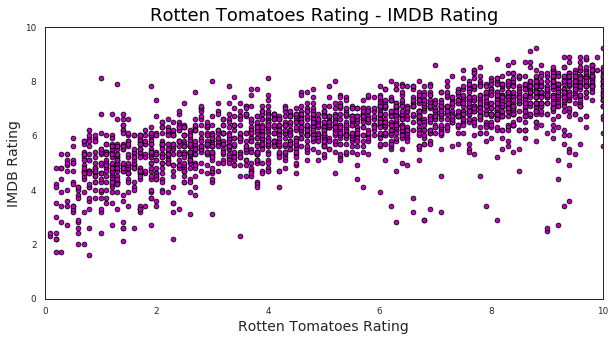

In [28]:
#making RTRating and IMDBRating Scatterplot
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'RTRating', y='IMDBRating', data = rtr_imdbr_df, facecolor = 'm', edgecolor = 'black')

plt.title('Rotten Tomatoes Rating - IMDB Rating',color = 'black', fontsize = 18)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Rotten Tomatoes Rating', fontsize = 14)
plt.ylabel('IMDB Rating', fontsize = 14)

plt.savefig('RTR_IMDB_Ratings_Scatterplot.png')

Rotten Tomatoes Rating and IMDB Rating Scatterplot

As we can see from the Rotten Tomatoes – IMDB Rating Scatterplot there is a strong linear positive correlation between them. Small values of Rotten Tomatoes Rating correspond to small values of IMDB Rating. Large values of Rotten Tomatoes Rating correspond to large values of IMDB Rating.
If we take a careful look, we see that when people vote movies under 5 in Rotten Tomatoes, people in IMDB vote (for the same movies) a litle higher. However, when people vote above 6 in Rotten Tomatoes, people in IMDB vote lower than those in Rotten, still above 6.

In [29]:
#Pearson Correlation Coefficient: RTRating and IMDBRating
pd.options.display.float_format = '{:.6f}'.format
rtr_imdbr_df.corr(method = 'pearson')

,RTRating,IMDBRating
RTRating,1.000000,0.742951
IMDBRating,0.742951,1.000000


In [30]:
#Spearman Correlation Coefficient: RTRating and IMDBRating
rtr_imdbr_df.corr(method = 'spearman')

,RTRating,IMDBRating
RTRating,1.000000,0.776429
IMDBRating,0.776429,1.000000


In [31]:
#2 sample z-test1:  RTRating and IMDBRating
print('H0: People in Rotten Tomatoes and  IMDB vote similarly.\n ')

ztest, pval = stests.ztest(rtr_imdbr_df['RTRating'], x2 = rtr_imdbr_df['IMDBRating'], value = 0 , alternative = 'two-sided')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')

H0: People in Rotten Tomatoes and  IMDB vote similarly.
 
p-value:  7.21302915029273e-43

Reject Null Hypothesis (H0)


In [32]:
#2 sample z-test2:  RTRating and IMDBRating
print('H1: People in Rotten Tomatoes vote higher than in IMDB.\n ')

ztest, pval = stests.ztest(rtr_imdbr_df['RTRating'], x2 = rtr_imdbr_df['IMDBRating'], value = 0 , alternative = 'larger')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H1)')

else:
    
    print('\nAccept Null Hypothesis (H1)')
    
pd.options.display.float_format = '{:.1f}'.format

H1: People in Rotten Tomatoes vote higher than in IMDB.
 
p-value:  1.0

Accept Null Hypothesis (H1)


In [33]:
#making one DataFrame with Genres (1 and 2 ) and Gross
gross_genre_df = pd.DataFrame(df['Gross'])
gross_genre_df['Genre1'] = genres_df[['First']]
gross_genre_df.dropna(inplace = True)
gross_genre_df['Genre2'] = genres_df[['Second']]

#print(gross_genre_df)

In [34]:
#Grouping by genres and finding mean gross (in both genre dfs), then putting them all in one DataFrame
m_gross_genre1_df = gross_genre_df.groupby('Genre1').mean().reset_index()
m_gross_genre2_df = gross_genre_df.groupby('Genre2').mean().reset_index()
m_gross_genre2_df = m_gross_genre2_df.rename(columns = {'Genre2' : 'Genre1'})
m_gross_genre1_df = m_gross_genre1_df.append(m_gross_genre2_df, ignore_index = True)
m_gross_genre1_df = m_gross_genre1_df.rename(columns = {'Genre1' : 'Genre', 'Gross' : 'Mean Gross'})

m_gross_genre1_df.sort_values('Mean Gross', ascending = False, inplace = True)

#print(m_gross_genre1_df)

In [35]:
#Grouping by genres and finding std gross (in both genre dfs), then putting them all in one DataFrame
std_gross_genre1_df = gross_genre_df.groupby('Genre1').std().reset_index()
std_gross_genre2_df = gross_genre_df.groupby('Genre2').std().reset_index()
std_gross_genre2_df = std_gross_genre2_df.rename(columns = {'Genre2' : 'Genre1'})

std_gross_genre1_df = std_gross_genre1_df.append(std_gross_genre2_df, ignore_index = True)
std_gross_genre1_df = std_gross_genre1_df.rename(columns = {'Genre1' : 'Genre', 'Gross' : 'Std Gross'})

#print(std_gross_genre1_df)

In [36]:
#calculating the confidence intervals ci lower and ci upper 
conf_int = stats.norm.interval(0.95, loc = m_gross_genre1_df['Mean Gross'], scale = std_gross_genre1_df['Std Gross']/np.sqrt(std_gross_genre1_df['Std Gross'].count()))
conf_int = np.array(conf_int)

#print(conf_int)

In [37]:
# putting ci lower and ci upper in our m_gross_genre1_df DataFrame
m_gross_genre1_df['Bottom Error Ci'] = conf_int[0]
m_gross_genre1_df['Top Error Ci'] = conf_int[1]
m_gross_genre1_df.reset_index(drop = True, inplace = True)

#print(m_gross_genre1_df)

In [38]:
# fixing the negative bottom error CIs and give them the Mean Gross number
# so as to be 0 when the errorbar calculates xerror (it calculates: mean - bottom error ci)
m_gross_genre1_df['Bottom Error Ci'] = m_gross_genre1_df['Bottom Error Ci'].mask(m_gross_genre1_df['Bottom Error Ci'] < 0, m_gross_genre1_df['Mean Gross'])

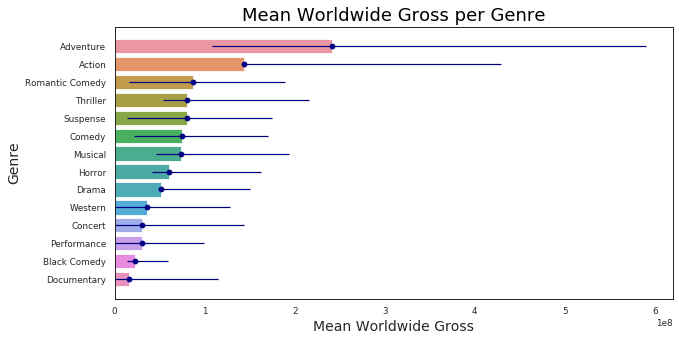

In [39]:
#making the barplot of Mean Worldwide Gross per Genre
plt.figure(figsize=(10, 5))

a = sns.barplot(x = 'Mean Gross', y = 'Genre', data = m_gross_genre1_df)

plt.errorbar(x = 'Mean Gross', y = 'Genre', xerr =[m_gross_genre1_df['Bottom Error Ci'], m_gross_genre1_df['Top Error Ci']],  data = m_gross_genre1_df, fmt = 'o', c = 'navy')

plt.title('Mean Worldwide Gross per Genre', color = 'black', fontsize = 18)
plt.xlabel('Mean Worldwide Gross', fontsize = 14)
plt.ylabel('Genre', fontsize = 14)

plt.savefig('mean_gross_genre_barplot.png')

Mean Worldwide Gross per Genre Barplot

Firstly, it is clear that adventure movies are far more profitable than the rest. 
Interesting is, that drama movies, the most preferable among production companies, are not that prosperous at all and that is also for comedies. Secondly, the confidence interval for adventure movies is enormous! As it comes 4rth in the production ranking (checking back on the previous barplot about popularity of genres), the reason seems to be that it has wide dispersion.

In [40]:
#2 sample T-test :"Adventure - Action" Genre Mean Worldwide Gross 
pd.options.display.float_format = '{:.6f}'.format

adv = df[df['Genre']=='Adventure']
adv = adv[['Genre', 'Gross']]
action = df[df['Genre']=='Action']
action = action[['Genre', 'Gross']]

print('H0: There is no significant difference between adventure movies mean gross and action movies mean gross.\n ')

ttest, pval = stats.ttest_ind(adv['Gross'], action['Gross'], equal_var = False)
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')

H0: There is no significant difference between adventure movies mean gross and action movies mean gross.
 
p-value:  5.520054519574185e-07

Reject Null Hypothesis (H0)


In [41]:
#2 sample T-test : "Comedy - Drama" Genre Mean Worldwide Gross 
comedy = df[df['Genre']=='Comedy']
comedy = comedy[['Genre', 'Gross']]
drama = df[df['Genre']=='Drama']
drama = drama[['Genre', 'Gross']]

print('H0: There is no significant difference between comedy movies mean gross and drama movies mean gross.\n ')

ttest, pval = stats.ttest_ind(comedy['Gross'], drama['Gross'], equal_var = False)
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')


H0: There is no significant difference between comedy movies mean gross and drama movies mean gross.
 
p-value:  4.012664537132461e-06

Reject Null Hypothesis (H0)


In [42]:
#2 sample T-test : "Drama - Comedy" Genre Mean Worldwide Gross 
drama = df[df['Genre']=='Drama']
drama = drama[['Genre', 'Gross']]
western = df[df['Genre']=='Western']
western = western[['Genre', 'Gross']]

print('H0: There is no significant difference between drama movies mean gross and western movies mean gross.\n ')

ttest, pval = stats.ttest_ind(drama['Gross'], western['Gross'], equal_var = False)
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')

pd.options.display.float_format = '{:.1f}'.format

H0: There is no significant difference between drama movies mean gross and western movies mean gross.
 
p-value:  0.23096572640997634

Accept Null Hypothesis (H0)


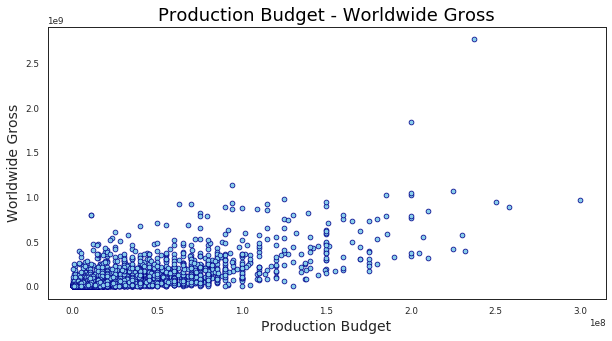

In [43]:
#--------my data mining problem--------making Production Budget and Worldwide Gross Scatterplot
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'Budget', y='Gross', data = budget_gross_df, facecolor = 'skyblue', edgecolor ='darkblue')

plt.title('Production Budget - Worldwide Gross',color = 'black', fontsize = 18)

plt.xlabel('Production Budget', fontsize = 14)
plt.ylabel('Worldwide Gross', fontsize = 14)

plt.savefig('Budget_Gross_Scatterplot.png')


Production Budget and Worldwide Gross Scatterplot

Scatterplot gives us a first thought that the bigger the budget the better the gross ( le8 vs le9). 
It follows a weak linear positive correlation, data points are less as budget goes up. 
Most of the data points are clustered in the left down corner.


In [44]:
#Pearson Correlation Coefficient: Production Budget and Worldwide Gross
pd.options.display.float_format = '{:.6f}'.format
budget_gross_df.corr(method = 'pearson')

,Gross,Budget
Gross,1.000000,0.665871
Budget,0.665871,1.000000


In [45]:
#Spearman Correlation Coefficient: Production Budget and Worldwide Gross
budget_gross_df.corr(method = 'spearman')

,Gross,Budget
Gross,1.000000,0.677304
Budget,0.677304,1.000000


In [46]:
#2 sample z-test1: Production Budget and Worldwide Gross
print('H0: Grosses are larger than budgets invested.\n ')

ztest, pval = stests.ztest(budget_gross_df['Gross'], x2 = budget_gross_df['Budget'], value = 0 , alternative = 'larger')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')

H0: Grosses are larger than budgets invested.
 
p-value:  1.8468088059599744e-88

Reject Null Hypothesis (H0)


In [47]:
#2 sample z-test2: Production Budget and Worldwide Gross
print('H1: Grosses are smaller than budgets invested.\n ')

ztest, pval = stests.ztest(budget_gross_df['Gross'], x2 = budget_gross_df['Budget'], value = 0 , alternative = 'smaller')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H1)')

else:
    
    print('\nAccept Null Hypothesis (H1)')

pd.options.display.float_format = '{:.1f}'.format

H1: Grosses are smaller than budgets invested.
 
p-value:  1.0

Accept Null Hypothesis (H1)


In [48]:
# making the DataFrame for the mean() RTRating and mean() IMDBRating per decade
ratings_dates_df = df[['RTRating', 'IMDBRating', 'Date']]
ratings_dates_df = ratings_dates_df.rename(columns = {'RTRating' : 'Rotten Tomatoes', 'IMDBRating': 'IMDB'})
ratings_dates_df = ratings_dates_df.groupby((ratings_dates_df.Date//10)*10).mean()

ratings_dates_df = ratings_dates_df[['Rotten Tomatoes', 'IMDB']]
ratings_dates_df.reset_index(level = 0, inplace = True)
ratings_dates_df = ratings_dates_df.rename(columns = {'Date' : 'Decade'})

ratings_dates_df = pd.melt(ratings_dates_df, id_vars = 'Decade', var_name = 'Website', value_name = 'Rating')

#print(ratings_dates_df)

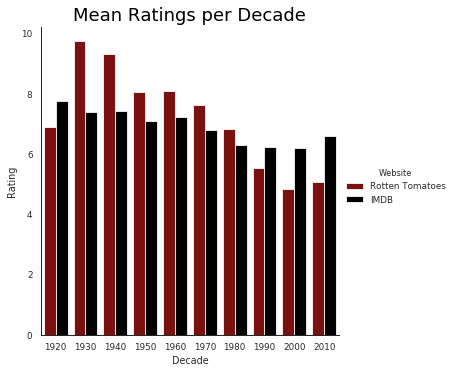

In [49]:
#creating catplot for Mean Ratings per Decade
colors = ['darkred', 'black']
palette = sns.color_palette(colors)
sns.catplot(x = 'Decade', y = 'Rating', hue = 'Website', data = ratings_dates_df, palette = palette, kind = 'bar')

plt.title('Mean Ratings per Decade', color = 'black', fontsize = 18)

plt.savefig('ratings_decade_catplot.png')

Mean Ratings per Decade 2-Barplot

From this plot, we realize that ratings are higher back in the years that what they are today.
This catplot gives us more info about the votes as it categorizes them with different colors. 
Another inference is that IMDB Votes are more symmetric than Rotten Tomatoes votes, which indicates that 
users think movies are not that bad nowadays, whereas, critics in Rotten Tomatoes seem to be dissapointed 
by recent movies. 

So yes, ratings are worse than what they used to be.

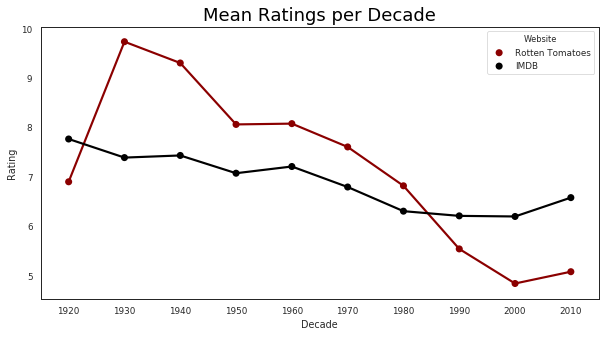

In [50]:
#creating pointplot for Mean Ratings per Decade
plt.figure(figsize=(10, 5))
colors = ['darkred', 'black']
palette = sns.color_palette(colors)
sns.pointplot(x = 'Decade', y = 'Rating', hue = 'Website', data = ratings_dates_df, palette = palette, kind = 'point')

plt.title('Mean Ratings per Decade', color = 'black', fontsize = 18)

plt.savefig('ratings_decade_pointplot.png')

Mean Ratings per Decade Pointplot

Pointplot shows exactly the “line drop” we mentioned above. The red line used to be really high, even higher than the black, and nearby 1985 dropped rappidly under the black one.


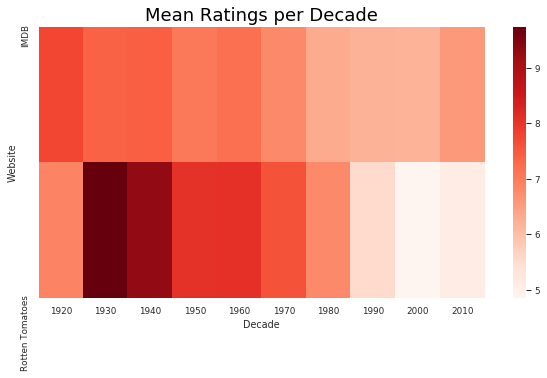

In [51]:
#creating Heatmap for Mean Ratings per Decade
plt.figure(figsize=(10, 5))
sns.heatmap(ratings_dates_df.pivot('Website', 'Decade', 'Rating'), cmap='Reds')

plt.title('Mean Ratings per Decade', color = 'black', fontsize = 18)

plt.savefig('ratings_decade_heatmap.png')

Mean Ratings per Decade Heatmap

The color-coding here helps us understand when users voted higher. 
Rotten Tomatoes critics voted higher from 1930 to 1960 movies and color turns whitey the last two 
decades. 
IMDB users stay in orange-beige palette throughout most of the decades, with a more whiter tone from 1980 to 2000.
 
To sum up, recent movies are indeed low rated, the decline is evident.